#### Import libraries

In [23]:
import os
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import box
from rasterio.features import rasterize
import numpy as np
import rasterio
from rasterio.plot import show
from acquisition_alignment.dl_functions import download_osm, get_building_bbox, download_sentinel2_images_openeo
from acquisition_alignment.connect_openeo import connect_to_openeo
from acquisition_alignment.plt_functions import plot_city_buildings, rgb_image, single_band_image, overlay_image, irb_image, get_epsg_from_tif, reproject_gdf

from preparation.preparation import create_building_mask, create_patches
from tqdm import tqdm
import torch
import torch.nn as nn

#### Define 10 "big" cities

In [4]:
# List of 10 'big' cities + Test city
city_names = ["Berlin", "Koeln", "Frankfurt", "Stuttgart", "Dortmund", "Duesseldorf", "Bremen", "Leipzig", "Dresden", "Muenchen", "Hamburg"]

### 1.1 Data Acquisition and Alignment

#### Loop through 10 'big' cities and download OSM files for each

In [ ]:
# 1 min
pyrosm_path = f"acquisition_alignment/pyrosm_cities/"
os.makedirs(pyrosm_path, exist_ok=True)

# Loop through each city
for city in city_names:
    #Download and process OSM data
    download_osm(city, pyrosm_path)
    print(f"Download of {city} done.\n")

#### Load buildings and bboxes of the cities

In [ ]:
# ~11 min
cities_data = {}
for city in city_names:
    buildings_gdf, bbox = get_building_bbox(pyrosm_path, city)
    # Saving buildings_gdf to a shapefile
    # save_to_shapefile(buildings_gdf, bbox, city)
    cities_data[city] = [buildings_gdf, bbox]
    print(f"Get buildings and boundaries of {city} done.\n")


#### Download Satellite images (.tif files) and plotting

##### Connect to openeo.dataspace.copernicus

In [ ]:
# Connect to OpenEO
connection = connect_to_openeo()

##### Download Sentinel 2 L2a Data

In [ ]:
# 30 - 40 min
dates_interval = ["2021-06-01T12:00:00Z", "2021-07-30T12:01:00Z"]
cloud_cover_percentage = 6

for city in city_names:
    openeo_path = f"acquisition_alignment/openeo_cities/{city}/"
    # Ensure the directory exists
    os.makedirs(openeo_path, exist_ok=True)

    # Download Sentinel-2 L2a images
    _, bbox = cities_data[city]
    download_sentinel2_images_openeo(connection, bbox, dates_interval, cloud_cover_percentage, openeo_path)

#### Buildings Plot and Images

In [ ]:
band_index = 1  # For single band. Band index to read (1 for B04, 2 for B03, 3 for B02, 4 for B08) (cmap=gray anyway). Start index is 1 because rasterio.

# Loop through each city in the dictionary and save image of the buildings of the city
for city, data in cities_data.items():
    # Path to the Sentinel-2 L2a image of a city
    sentinel2_path = f"acquisition_alignment/openeo_cities/{city}/{city}.tif"

    buildings_gdf, _ = data

    # Make directory for the images (for city). Ensure the directory exists
    images_save_dir = f"acquisition_alignment/images/{city}/"
    os.makedirs(images_save_dir, exist_ok=True)

    print("1 (a) Buildings from OpenStreetMaps.")
    plot_city_buildings(city, buildings_gdf, images_save_dir)

    print("1 (b) RGB Bands from Sentinel 2.")
    rgb_image(sentinel2_path, images_save_dir)

    print("2 (a) Single Band.")
    single_band_image(sentinel2_path, images_save_dir, band_index)

    print("2 (b) Overlap Buildings from OSM onto Sentinel-2 image.")
    overlay_image(buildings_gdf, sentinel2_path, images_save_dir, band_index)

    print("2 (c) IRB")
    irb_image(sentinel2_path, images_save_dir)
    print(f"Plotting for {city} done")
    break # One should be enough to be sure projection is correct

### 1.2 Dataset Preparation

##### Save huge mask for each huge city in a .tif file

In [ ]:
# 12.2 min
# Load the Sentinel-2 image
for city, data in cities_data.items():
    image_path = f"acquisition_alignment/openeo_cities/{city}/{city}.tif"  # Iterate over each of the 10 Sentinel files
    buildings_gdf, _ = data
    satellite_crs = get_epsg_from_tif(image_path)
    buildings_gdf = reproject_gdf(buildings_gdf, satellite_crs) # OSM to Satellite

    with rasterio.open(image_path) as src:
        transform = src.transform
        width = src.width
        height = src.height

        # Create the building mask
        buildings_mask = create_building_mask(buildings_gdf, transform, width, height) # 0/1 = black white

        # Save the building mask as a new .tif file
        mask_path = f'acquisition_alignment/openeo_cities/{city}/{city}_buildings_mask.tif'
        with rasterio.open(
            mask_path,
            'w',
            driver='GTiff',
            height=buildings_mask.shape[0],
            width=buildings_mask.shape[1],
            count=1,
            dtype=buildings_mask.dtype,  # use the same data type as the mask
            crs=src.crs,
            transform=transform,
        ) as dst:
            dst.write(buildings_mask, 1)

##### Load created .tif masks and look at them

Koeln
Unique values in mask: [0 1]


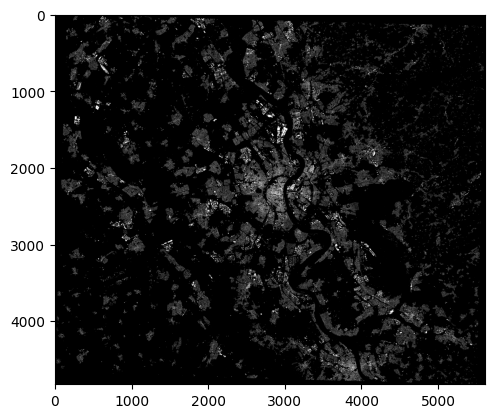

Frankfurt
Unique values in mask: [0 1]


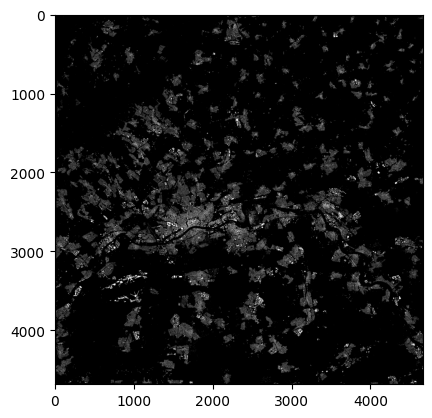

In [8]:
for city in city_names[1:3]:
    mask_path = f'acquisition_alignment/openeo_cities/{city}/{city}_buildings_mask.tif'
    # Load the building mask
    print(f"{city}")
    with rasterio.open(mask_path) as src:
        buildings_mask = src.read(1)  # Mask is in the first band

    # Check the unique values in the mask
    unique_values = np.unique(buildings_mask)
    print("Unique values in mask:", unique_values)

    # Display the mask with a grayscale colormap
    show(buildings_mask, cmap='gray')

##### Make Patches for Train Set

In [9]:
# Parameters
patch_size = 128  # Define the patch size (32, 64, or 128)

# Initialize lists to store all image and mask patches
all_img_patches = []
all_mask_patches = []

# Iterate over each city to create patches
for city in city_names[1:-2]: # 0 is Berlin, do not include into patches. Last 2 cities (Hamburg and Muenchen are used for validation)
    image_path = f"acquisition_alignment/openeo_cities/{city}/{city}.tif"  # Path to the large image
    mask_path = f"acquisition_alignment/openeo_cities/{city}/{city}_buildings_mask.tif"  # Path to the binary mask image
    
    # Create patches for current city
    img_patches, mask_patches = create_patches(image_path, mask_path, patch_size)
    
    # Append current city patches to the lists
    all_img_patches.append(img_patches)
    all_mask_patches.append(mask_patches)

# Concatenate all city patches along the first dimension (N)
all_img_patches = np.concatenate(all_img_patches, axis=0)
all_mask_patches = np.concatenate(all_mask_patches, axis=0)

In [10]:
# Print shapes to verify
print(f"Image patches shape: {all_img_patches.shape}")  # Expected: [N, C, H, W]
print(f"Mask patches shape: {all_mask_patches.shape}")  # Expected: [N, H, W]

Image patches shape: (11591, 4, 128, 128)
Mask patches shape: (11591, 128, 128)


In [11]:
# Save image and mask tensors as .npy files
np.save('preparation/all_img_patches.npy', all_img_patches)
np.save('preparation/all_mask_patches.npy', all_mask_patches)

print("Saved image and mask tensors as .npy files.")

Saved image and mask tensors as .npy files.


In [12]:
# Function to load whole image and mask and return
def load_image_and_mask(image_path, mask_path):
    with rasterio.open(image_path) as src:
        img = src.read()

    with rasterio.open(mask_path) as src_mask:
        mask_img = src_mask.read(1)

    return img, mask_img

# Define paths to validation images and masks
validation_data = [
    {"image": "acquisition_alignment/openeo_cities/Hamburg/Hamburg_cropped.tif", "mask": "acquisition_alignment/openeo_cities/Hamburg/Hamburg_buildings_mask_cropped.tif"},
    {"image": "acquisition_alignment/openeo_cities/Muenchen/Muenchen_cropped.tif", "mask": "acquisition_alignment/openeo_cities/Muenchen/Muenchen_buildings_mask_cropped.tif"}
]

# Initialize lists to store image and mask tensors
image_tensors = []
mask_tensors = []

# Load validation tensors into memory and store in lists
for data in validation_data:
    img_path = data["image"]
    mask_path = data["mask"]
    
    img_tensor, mask_tensor = load_image_and_mask(img_path, mask_path)
    image_tensors.append(img_tensor)
    mask_tensors.append(mask_tensor)

# Convert lists to numpy arrays
image_tensors = np.array(image_tensors)
mask_tensors = np.array(mask_tensors)

In [14]:
print(f"Image patches shape: {image_tensors.shape}")  # Expected: [N, C, H, W]
print(f"Mask patches shape: {mask_tensors.shape}")  # Expected: [N, H, W]

Image patches shape: (2, 4, 1360, 1425)
Mask patches shape: (2, 1360, 1425)


In [15]:
# Save image and mask tensors as .npy files
np.save('preparation/val_image_tensors.npy', image_tensors)
np.save('preparation/val_mask_tensors.npy', mask_tensors)

print("Saved image and mask tensors as .npy files.")

Saved image and mask tensors as .npy files.


#### Crop 2 last cities (Hamburg and Muenchen) for Validation

##### Crop Hamburg

In [ ]:
image_path = f'acquisition_alignment/openeo_cities/Hamburg/Hamburg.tif'

import rasterio
from rasterio.plot import show
from rasterio.windows import Window
import matplotlib.pyplot as plt

# Load the .tif file
with rasterio.open(image_path) as src:
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height

# Specify the upper left point (column and row from QGIS) and the desired width and height in pixels
upper_left_col = 3810  # example column (x) from QGIS
upper_left_row = 2365  # example row (y) from QGIS
crop_width = 1425     # desired width in pixels
crop_height = 1360    # desired height in pixels

# Define the window to crop
window = Window(upper_left_col, upper_left_row, crop_width, crop_height)

# Crop the image
with rasterio.open(image_path) as src:
    cropped_image = src.read(window=window)
    cropped_transform = src.window_transform(window)

# Save the cropped image
output_path = 'acquisition_alignment/openeo_cities/Hamburg/Hamburg_cropped.tif'
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=crop_height,
    width=crop_width,
    count=4,  # Number of bands
    dtype=cropped_image.dtype,
    crs=crs,
    transform=cropped_transform,
) as dst:
    for i in range(1, 5):
        dst.write(cropped_image[i-1], i) # raster bands are 1-indexed in rasterio

print(f"Cropped image saved to {output_path}")


##### Create mask for cropped Hamburg

In [ ]:
import geopandas as gpd
import rasterio
from shapely.geometry import box
from rasterio.features import rasterize
import numpy as np

# Load the cropped image to get the CRS and transform
cropped_image_path = 'acquisition_alignment/openeo_cities/Hamburg/Hamburg_cropped.tif'

with rasterio.open(cropped_image_path) as src:
    cropped_crs = src.crs
    cropped_transform = src.transform
    cropped_bounds = src.bounds
    cropped_width = src.width
    cropped_height = src.height


# Fix invalid geometries
buildings_gdf['geometry'] = buildings_gdf['geometry'].buffer(0)

# Reproject the buildings to match the CRS of the cropped image
buildings_gdf = buildings_gdf.to_crs(cropped_crs)

# Create a bounding box from the cropped image bounds
cropped_bbox = box(*cropped_bounds)

# Clip the buildings to the bounding box of the cropped image
buildings_clipped = gpd.clip(buildings_gdf, cropped_bbox)

# Create an empty mask array
mask = np.zeros((cropped_height, cropped_width), dtype=np.uint8)

# Define the out_shape and transform for rasterize
out_shape = (cropped_height, cropped_width)
transform = cropped_transform

# Rasterize the clipped buildings
if not buildings_clipped.empty:
    mask = rasterize(
        [(geom, 1) for geom in buildings_clipped.geometry],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=np.uint8
    )

# Save the mask as a .tif file
mask_output_path = 'acquisition_alignment/openeo_cities/Hamburg/Hamburg_buildings_mask_cropped.tif'

with rasterio.open(
    mask_output_path,
    'w',
    driver='GTiff',
    height=cropped_height,
    width=cropped_width,
    count=1,
    dtype=mask.dtype,
    crs=cropped_crs,
    transform=transform,
) as dst:
    dst.write(mask, 1)

print(f"Building mask saved to {mask_output_path}")

##### Crop Muenchen

In [ ]:

image_path = f'acquisition_alignment/openeo_cities/Muenchen/Muenchen.tif'

import rasterio
from rasterio.plot import show
from rasterio.windows import Window
import matplotlib.pyplot as plt

# Load the .tif file
with rasterio.open(image_path) as src:
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height

# Specify the upper left point (column and row from QGIS) and the desired width and height in pixels
upper_left_col = 3015  # example column (x) from QGIS
upper_left_row = 2660  # example row (y) from QGIS
crop_width = 1425     # desired width in pixels
crop_height = 1360    # desired height in pixels

# Define the window to crop
window = Window(upper_left_col, upper_left_row, crop_width, crop_height)

# Crop the image
with rasterio.open(image_path) as src:
    cropped_image = src.read(window=window)
    cropped_transform = src.window_transform(window)

# Save the cropped image
output_path = 'acquisition_alignment/openeo_cities/Muenchen/Muenchen_cropped.tif'
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=crop_height,
    width=crop_width,
    count=4,  # Number of bands
    dtype=cropped_image.dtype,
    crs=crs,
    transform=cropped_transform,
) as dst:
    for i in range(1, 5):
        dst.write(cropped_image[i-1], i) # raster bands are 1-indexed in rasterio

print(f"Cropped image saved to {output_path}")

##### Create mask for cropped Muenchen

In [ ]:
# Load the cropped image to get the CRS and transform
cropped_image_path = 'acquisition_alignment/openeo_cities/Muenchen/Muenchen_cropped.tif'

with rasterio.open(cropped_image_path) as src:
    cropped_crs = src.crs
    cropped_transform = src.transform
    cropped_bounds = src.bounds
    cropped_width = src.width
    cropped_height = src.height


# Fix invalid geometries
buildings_gdf['geometry'] = buildings_gdf['geometry'].buffer(0)

# Reproject the buildings to match the CRS of the cropped image
buildings_gdf = buildings_gdf.to_crs(cropped_crs)

# Create a bounding box from the cropped image bounds
cropped_bbox = box(*cropped_bounds)

# Clip the buildings to the bounding box of the cropped image
buildings_clipped = gpd.clip(buildings_gdf, cropped_bbox)

# Create an empty mask array
mask = np.zeros((cropped_height, cropped_width), dtype=np.uint8)

# Define the out_shape and transform for rasterize
out_shape = (cropped_height, cropped_width)
transform = cropped_transform

# Rasterize the clipped buildings
if not buildings_clipped.empty:
    mask = rasterize(
        [(geom, 1) for geom in buildings_clipped.geometry],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=np.uint8
    )

# Save the mask as a .tif file
mask_output_path = 'acquisition_alignment/openeo_cities/Muenchen/Muenchen_buildings_mask_cropped.tif'

with rasterio.open(
    mask_output_path,
    'w',
    driver='GTiff',
    height=cropped_height,
    width=cropped_width,
    count=1,
    dtype=mask.dtype,
    crs=cropped_crs,
    transform=transform,
) as dst:
    dst.write(mask, 1)

print(f"Building mask saved to {mask_output_path}")


In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Path to the building mask file
mask_file_path = 'acquisition_alignment/openeo_cities/Muenchen/Muenchen_buildings_mask_cropped.tif'

# Load the mask
with rasterio.open(mask_file_path) as mask_src:
    mask = mask_src.read(1)  # Read the first band

# Display the mask
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.title('Building Mask Muenchen')
plt.axis('off')
plt.show()


### 1.3 Modeling and Tuning

#### Define BaselineCNN Hyperparameters

In [33]:
C = 4  # Number of channels in the input images (RGB+NIR)
LEARNING_RATE = 0.001  # Learning rate for the optimizer
BATCH_SIZE = 32  # Batch size for training
NUM_EPOCHS = 10  # Number of epochs for training
WEIGHT_DECAY = 0 # 1e-4  # Weight decay for regularization
# Early stopping hyperparameters
patience = 3
delta = 0.001
# optimizer tpye

#### Define BaselineCNN

In [34]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the neural network model
class BaselineCNN(nn.Module):
    def __init__(self, in_channels):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 1, kernel_size=1, padding=0)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        return x

# Assuming C is the number of channels in the input images
C = 4  # For RGB+NIR images

# Create an instance of the model
model = BaselineCNN(in_channels=C).to(device)

Using device: cuda


#### Define Data Sets for BaselineCNN

In [35]:
# Convert numpy arrays to PyTorch tensors and move to GPU if available
train_images = torch.tensor(all_img_patches, dtype=torch.float32).to(device)
train_masks = torch.tensor(all_mask_patches, dtype=torch.float32).to(device)
val_images = torch.tensor(image_tensors, dtype=torch.float32).to(device)
val_masks = torch.tensor(mask_tensors, dtype=torch.float32).to(device)

# Create TensorDataset and DataLoader for training and validation
train_dataset = torch.utils.data.TensorDataset(train_images, train_masks)
train_loader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(val_images, val_masks)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)  # Use batch_size=1 for validation

#### Loss and Optimizer of the BaselineCNN

In [36]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), weight_decay=WEIGHT_DECAY, lr=LEARNING_RATE)  # Adam optimizer with learning rate 0.001

#### Train and Validate BaselineCNN

In [37]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3, delta=0.001):
    train_losses = []  # To store the training losses
    val_losses = []    # To store the validation losses
    best_val_loss = float('inf')
    early_stopping_counter = 0
    best_epoch = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        
        for images, masks in progress_bar:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            progress_bar.set_postfix({'Training Loss': running_loss / len(train_loader.dataset)})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Validate the model
        val_loss = validate(model, val_loader, criterion)
        val_losses.append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss - delta:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

    print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch + 1}")

    # Return train and validation losses for analysis
    return train_losses, val_losses

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")
    return val_loss

# Train the model
train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, patience, delta)

Epoch [1/10], Loss: 3.8112
Validation Loss: 0.3749


Epoch [2/10], Loss: 0.1071
Validation Loss: 0.3822


Epoch [3/10], Loss: 0.1033
Validation Loss: 0.3237


Epoch [4/10], Loss: 0.1017
Validation Loss: 0.3256


Epoch [5/10], Loss: 0.1001
Validation Loss: 0.3092


Epoch [6/10], Loss: 0.0983
Validation Loss: 0.3049


Epoch [7/10], Loss: 0.0982
Validation Loss: 0.3143


Epoch [8/10], Loss: 0.0970
Validation Loss: 0.3244


Epoch [9/10], Loss: 0.0964
Validation Loss: 0.3010


Epoch [10/10], Loss: 0.0960
Validation Loss: 0.2908
Best validation loss: 0.2908 at epoch 10


#### Save BaselineCNN Model

In [47]:
# Define the file path where to save the model
os.makedirs("models", exist_ok=True)
model_path = "models/baseline_model.pth"
# Save the trained model
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to models/baseline_model.pth


#### Visualize Train/validation Losses of the BaselineCNN

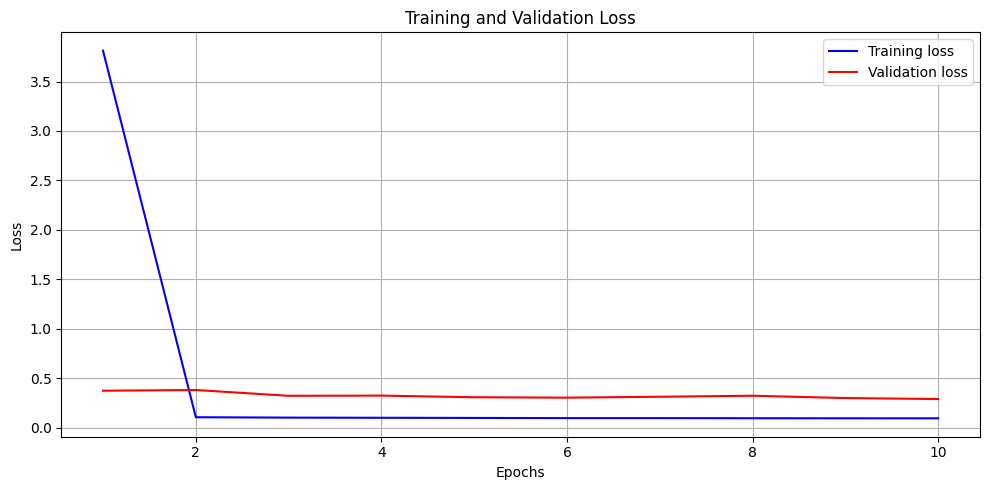

In [43]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are lists containing respective losses
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Ensures labels are not cut off in the saved image

# Save the plot as an image (choose a format, e.g., PNG, JPEG, PDF, SVG)
plt.savefig('modeling_tuning/training_validation_loss.png')  # Adjust dpi as needed

# Display the plot
plt.show()
plt.close()

#### Evaluate BaselineCNN on the Test Data

Accuracy on test image acquisition_alignment/openeo_cities/Berlin/Berlin.tif: 0.8486


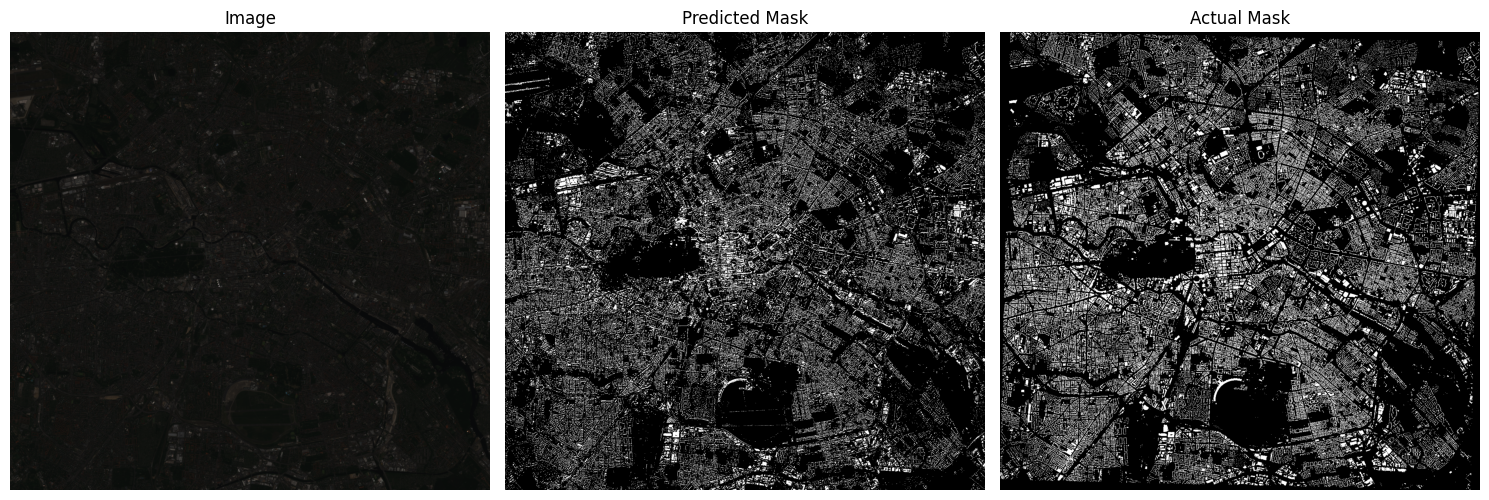

Evaluation complete. Results saved.


In [48]:
# Function to load whole image and mask and return
def load_image_and_mask(image_path, mask_path):
    with rasterio.open(image_path) as src:
        img = src.read()

    with rasterio.open(mask_path) as src_mask:
        mask_img = src_mask.read(1)

    img_tensor = torch.tensor(np.moveaxis(img, 0, -1), dtype=torch.float32)  # [H, W, C] to [C, H, W]
    mask_tensor = torch.tensor(mask_img, dtype=torch.float32)  # [H, W]

    return img_tensor, mask_tensor

# Function to calculate accuracy
def calculate_accuracy(preds, targets):
    preds = torch.sigmoid(preds)  # Sigmoid to convert logits to probabilities
    preds = (preds > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
    accuracy = (preds == targets).float().mean().item()  # Calculate accuracy
    return accuracy

import matplotlib.pyplot as plt

# Function to visualize images and masks
def visualize_results(image, predicted_mask, actual_mask, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Normalize image to range [0, 1] for display
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
    
    axes[0].imshow(image[:,:,:3]) # Only RGB
    axes[0].set_title("Image")
    axes[0].axis("off")
    
    axes[1].imshow(predicted_mask.cpu().numpy(), cmap='gray')
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")
    
    axes[2].imshow(actual_mask.cpu().numpy(), cmap='gray')
    axes[2].set_title("Actual Mask")
    axes[2].axis("off")
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


# Define paths to the test images and masks
test_data = [
    {"image": "acquisition_alignment/openeo_cities/Berlin/Berlin.tif", "mask": "acquisition_alignment/openeo_cities/Berlin/Berlin_buildings_mask.tif"}
]

# Initialize the model
model = BaselineCNN(in_channels=4)  # (RGB+NIR)

# Load the saved model state dict
model_path = "models/baseline_model.pth"
model.load_state_dict(torch.load(model_path))

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Evaluate the model on test data
accuracy_results = {}

for data in test_data:
    image_path = data["image"]
    mask_path = data["mask"]
    
    # Load test image and mask
    test_image, test_mask = load_image_and_mask(image_path, mask_path)
    
    # Add batch dimension to the image tensor
    test_image = test_image.unsqueeze(0).permute(0, 3, 1, 2).to(device)  # [1, C, H, W], move to device
    
    # Forward pass through the model
    with torch.no_grad():
        outputs = model(test_image)
    
    # Calculate accuracy
    accuracy = calculate_accuracy(outputs.squeeze(), test_mask.to(device))
    print(f"Accuracy on test image {image_path}: {accuracy:.4f}")
    
    # Save accuracy result
    accuracy_results[image_path] = accuracy
    
    # Convert outputs to binary predictions
    predicted_mask = torch.sigmoid(outputs.squeeze()) > 0.5
    
    # Visualize results and save plots
    visualize_results(test_image.squeeze(), predicted_mask, test_mask, save_path=f"modeling_tuning/results_{image_path.split('/')[-1]}.png")

# Save accuracy results to a file
with open("modeling_tuning/accuracy_results.txt", "w") as file:
    for image_path, accuracy in accuracy_results.items():
        file.write(f"{image_path}: {accuracy:.4f}\n")

print("Evaluation complete. Results saved.")

#### Define U-Net

### 1.4 Data Augmentation